# Cortical Magnification

## Introduction

### Dependencies

In [1]:
import os, sys, pimms, pandas, warnings
from pathlib import Path
from functools import reduce, partial

import numpy as np
import scipy as sp
import nibabel as nib
import neuropythy as ny

import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv
import torch

# This library is the companion to the notebook; it can be found in the src/
# directory of the github repository containing this notebook
# (github.com/noahbenson/cortical-magnification).
import cmag

### Dependency Initialization

In [2]:
# Additional matplotlib preferences:
font_data = {
    'family': 'sans-serif',
    'sans-serif': ['Arial', 'HelveticaNeue', 'Helvetica', 'Arial'],
    'size': 10,
    'weight': 'light'}
mpl.rc('font', **font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 288
mpl.rcParams['savefig.dpi'] = 576
mpl.rcParams['axes.unicode_minus'] = True

## Fitting Functions

#### Filters for use in Fitting

In [3]:
def filt_base(subdat, maxecc=7):
    return (subdat['eccentricity'] < maxecc)
def filt_wedge(subdat, minangle, maxangle):
    ang = subdat['polar_angle']
    return filt_base(subdat) & (ang >= minangle) & (ang <= maxangle)
def filt_ring(subdat, minecc, maxecc):
    ecc = subdat['eccentricity']
    return filt_base(subdat) & (ecc >= minecc) & (ecc <= maxecc)
def filt_sect(subdat, minang, maxang, minecc, maxecc):
    return (
        filt_base(subdat) &
        filt_wedge(subdat, minang, maxang) & 
        filt_ring(subdat, minecc, maxecc))

## Loading Data

In [4]:
# The subject IDs.
sids = cmag.hcp.sids

# The data for each subject.
data = {
    sid: (
        cmag.hcp.data.load(sid, 'lh'),
        cmag.hcp.data.load(sid, 'rh'))
    for sid in sids}

## Fitting

In [30]:
# We'll use this subject as an example:
(lhdata, rhdata) = lrdata = data[111312]

print('V1 Measured Surface Area (0–7°):')
lv1sa = np.sum(lhdata["surface_area"][lhdata['label'] == 1])
print(f' - lh: {lv1sa:7.2f}')
rv1sa = np.sum(rhdata["surface_area"][rhdata['label'] == 1])
print(f' - rh: {rv1sa:7.2f}')
print(f' - lr: {rv1sa+lv1sa:7.2f}')

V1 Measured Surface Area (0–7°):
 - lh: 1200.73
 - rh: 1290.52
 - lr: 2491.24


In [31]:
# First, fit the Horton & Hoyt (1991) model:

fit_lh = cmag.hcp.fit_cmag_data(
    lrdata,
    cmag.models.hh91, [1],
    hemifields=1,
    labels=1,
    filter=lambda d: d['hemisphere'] == 'lh')
fit_rh = cmag.hcp.fit_cmag_data(
    lrdata,
    cmag.models.hh91, [1],
    hemifields=1,
    labels=1,
    filter=lambda d: d['hemisphere'] == 'rh')
fit_lr = cmag.hcp.fit_cmag_data(
    lrdata,
    cmag.models.hh91, [1],
    hemifields=2,
    labels=1)

print('HH91 Model:')
for (k,f) in zip(['lh', 'rh', 'lr'], [fit_lh, fit_rh, fit_lr]):
    print(
        f' - {k}: total_area={float(f["total_area"]):7.2f},'
        f' b={float(f["x"][0]):5.3f}')

HH91 Model:
 - lh: total_area=5488.90, b=0.445
 - rh: total_area=6919.86, b=0.752
 - lr: total_area=6120.09, b=0.577


In [32]:
# Then fit the Beta distribution model:

fit_lh = cmag.hcp.fit_cmag_data(
    lrdata,
    cmag.models.beta, [0.8, 2.5],
    hemifields=1,
    labels=1,
    filter=lambda d: d['hemisphere'] == 'lh')
fit_rh = cmag.hcp.fit_cmag_data(
    lrdata,
    cmag.models.beta, [0.8, 2.5],
    hemifields=1,
    labels=1,
    filter=lambda d: d['hemisphere'] == 'rh')
fit_lr = cmag.hcp.fit_cmag_data(
    (lhdata, rhdata),
    cmag.models.beta, [0.8, 2.5],
    hemifields=2,
    labels=1)

print('Beta Model:')
for (k,f) in zip(['lh', 'rh', 'lr'], [fit_lh, fit_rh, fit_lr]):
    print(
        f' - {k}: total_area={float(f["total_area"]):7.2f},'
        f' a={float(f["x"][0]):5.3f},'
        f' b={float(f["x"][1]):5.3f}')

Beta Model:
 - lh: total_area=3036.78, a=0.940, b=19.260
 - rh: total_area=4501.15, a=0.961, b=11.307
 - lr: total_area=3722.40, a=0.935, b=14.019


In [33]:
# Fit the Horton & Hoyt (1991) model using just data from
# ±30° of the left/right horizontal meridian (90° ± 15°):

filt_lhm30deg = lambda data: filt_wedge(data, -90-15, -90+15)
filt_rhm30deg = lambda data: filt_wedge(data, 90-15, 90+15)

fit_lhm = cmag.hcp.fit_cmag_data(
    lrdata,
    cmag.models.hh91, [1],
    hemifields=30/360*2,
    labels=1,
    filter=filt_lhm30deg)
fit_rhm = cmag.hcp.fit_cmag_data(
    lrdata,
    cmag.models.hh91, [1],
    hemifields=30/360*2,
    labels=1,
    filter=filt_rhm30deg)

print('HH91 Model (30° around HM):')
print(
    f' - rhm: total_area={float(fit_rhm["total_area"]):7.2f},'
    f' b={float(fit_rhm["x"][0]):5.3f}')
print(
    f' - lhm: total_area={float(fit_lhm["total_area"]):7.2f},'
    f' b={float(fit_lhm["x"][0]):5.3f}')

HH91 Model (30° around HM):
 - rhm: total_area=9430.87, b=0.895
 - lhm: total_area=11190.34, b=1.290


In [22]:
# TODO: These are currently broken (use old code) and need to be updated!
# The new code doesn't do the iteration for you, we'll have to iterate
# through the subject IDs and run cmag.hcp.fit_cmag_data() on each subject.

# NOTE: everything below this point in the notebook was originally written
# for the old version of the code and needs to be adapted.

# Fitting beta functions; should take ~2-3 minutes to run.
#
# To fit only wedges (like the upper vertical meridian), we can use the
#   filter=lambda dat: filt_wedge(dat, -15, 15).
# For lower vertical this would be more like:
#   filter=lambda dat: filt_wedge(dat, 165, 180) | filt_wedge(dat, -180, -165)
#
# Keep in mind that the polar_angle data uses 0° as the upper vertical meridian,
# +90° as the right horizontal meridian, -90° as the left horizontal meridian,
# and ±180° as the lower vertical meridian.

fits = {k:[] for k in ('all', 'uvm', 'lvm', 'lhm', 'rhm')}

fits = cmag.hcp.fit_cmag_data(
    data,
    cmag.models.beta, [2, 50],
    lossfn=beta_loss,
    filter=None,
    bilateral=True,
    argtx=beta_argtx)
uvmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: filt_wedge(dat, -30, 30),
    bilateral=True,
    argtx=beta_argtx)
lvmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: (
        filt_wedge(dat, -180, -150) | filt_wedge(dat, 150, 180)),
    bilateral=True,
    argtx=beta_argtx)
lhmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: filt_wedge(dat, -120, -60),
    bilateral=True,
    argtx=beta_argtx)
rvmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: filt_wedge(dat, 60, 120),
    bilateral=True,
    argtx=beta_argtx)

### Plotting a Subject's Fits

In [ ]:
sid = 111312

(fig, axs) = plt.subplots(4,2, figsize=(7,7), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.15,0.1)
subdat = data[sid]
subfit = fits[sid]

for (ii,axcol) in enumerate(axs.T):
    hdat = subdat[ii]
    hfit = subfit[ii]
    for (lbl,fit,ax) in zip([1,2,3,4], hfit, axcol):
        ii = hdat['label'] == lbl
        ecc = hdat['eccentricity'][ii]
        sar = hdat['surface_area'][ii]
        ii = np.argsort(ecc)
        cum = np.cumsum(sar[ii])
        ecc = ecc[ii]
        ax.plot(ecc, cum, 'k-', lw=0.5)
        pre = cum[-1] * beta_form(ecc, *fit.x)
        ax.plot(ecc, pre, 'r-', lw=0.5)
        ax.fill_between(ecc, cum, pre, color='r', alpha=0.2)

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0,8])
for ax in axs[:,0]:
    ax.set_ylabel(r'Cum. Surface Area [cm$^2$]')
for ax in axs[-1]:
    ax.set_xlabel('Eccentricity [deg]')

plt.show()

### Plotting Beta Parameters for all Subjects

In [33]:
def plot_allparams(allparams, figwidth=4, dpi=288):
    nhem = allparams.shape[1]
    figheight = figwidth * 4 / nhem
    (fig,axs) = plt.subplots(
        4, nhem,
        figsize=(figwidth, figheight),
        dpi=dpi,
        sharex=True,
        sharey=True)
    fig.subplots_adjust(0,0,1,1,0.15,0.1)
    if nhem == 1:
        axs = axs[:,None]
    for (hii,axcol) in enumerate(axs.T):
        for (lbl,ax) in zip([1,2,3,4], axcol):
            (x,y) = allparams[:, hii, lbl-1, :].T
            ax.plot(x, y, 'ko', ms=0.5, alpha=0.5)
    for ax in axs.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0,2])
        ax.set_ylim([0,4])
    for ax in axs[:,0]:
        ax.set_ylabel(r'$\beta$')
    for ax in axs[-1]:
        ax.set_xlabel(r'$\alpha$')
    return fig

[0.9956781  1.40870172]


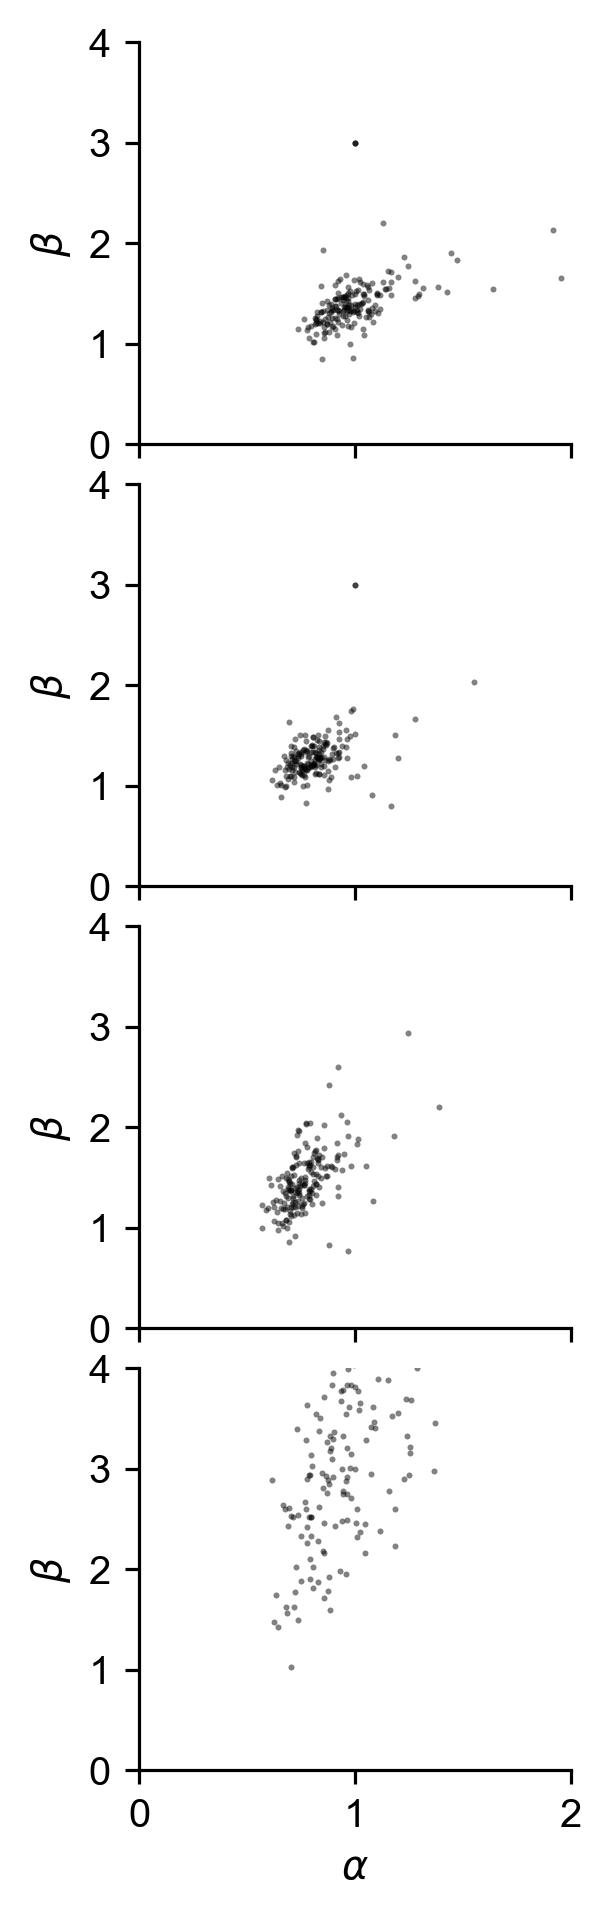

In [43]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in fits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()

[1.14210805 1.86588868]


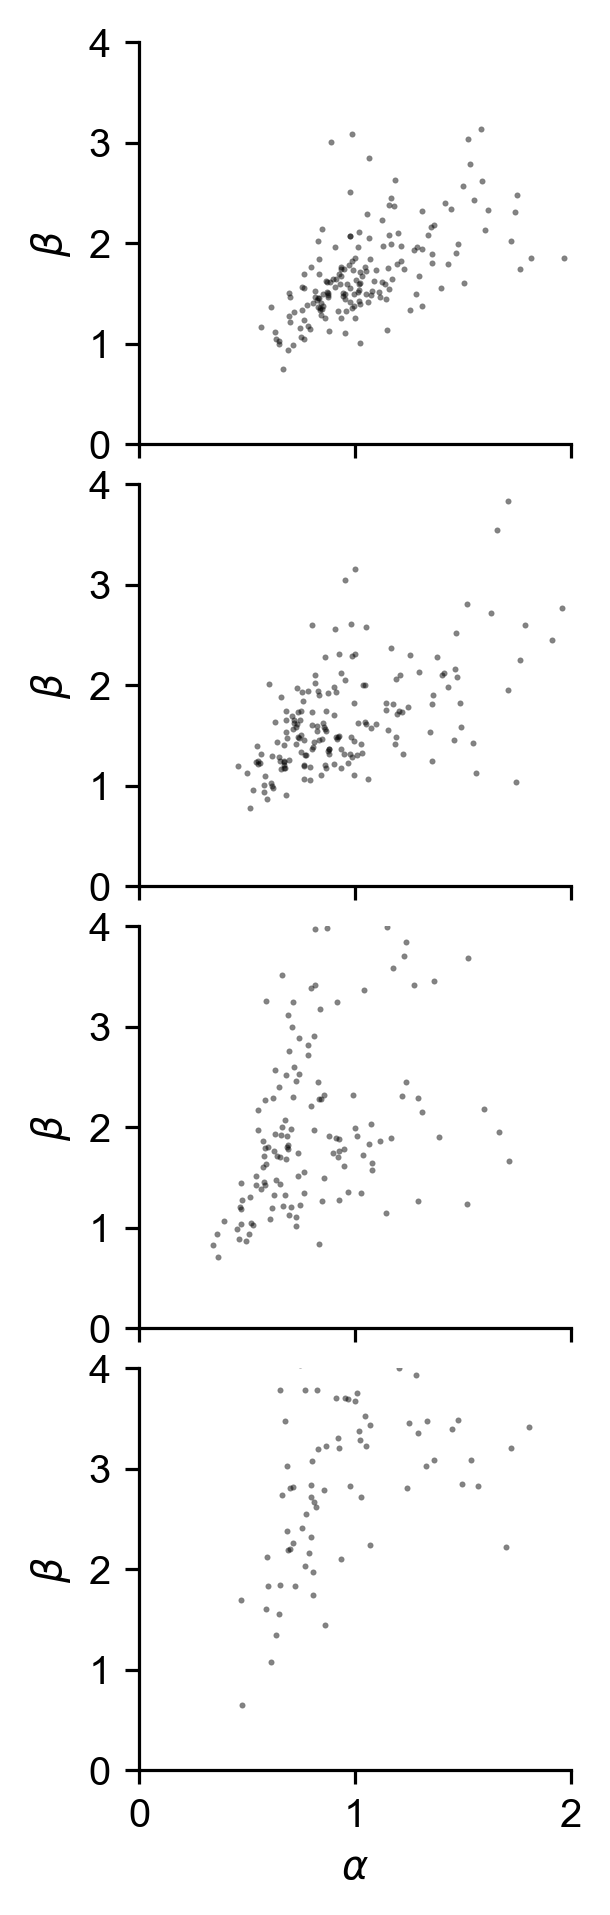

In [44]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in uvmfits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()

[0.99465396 1.44491643]


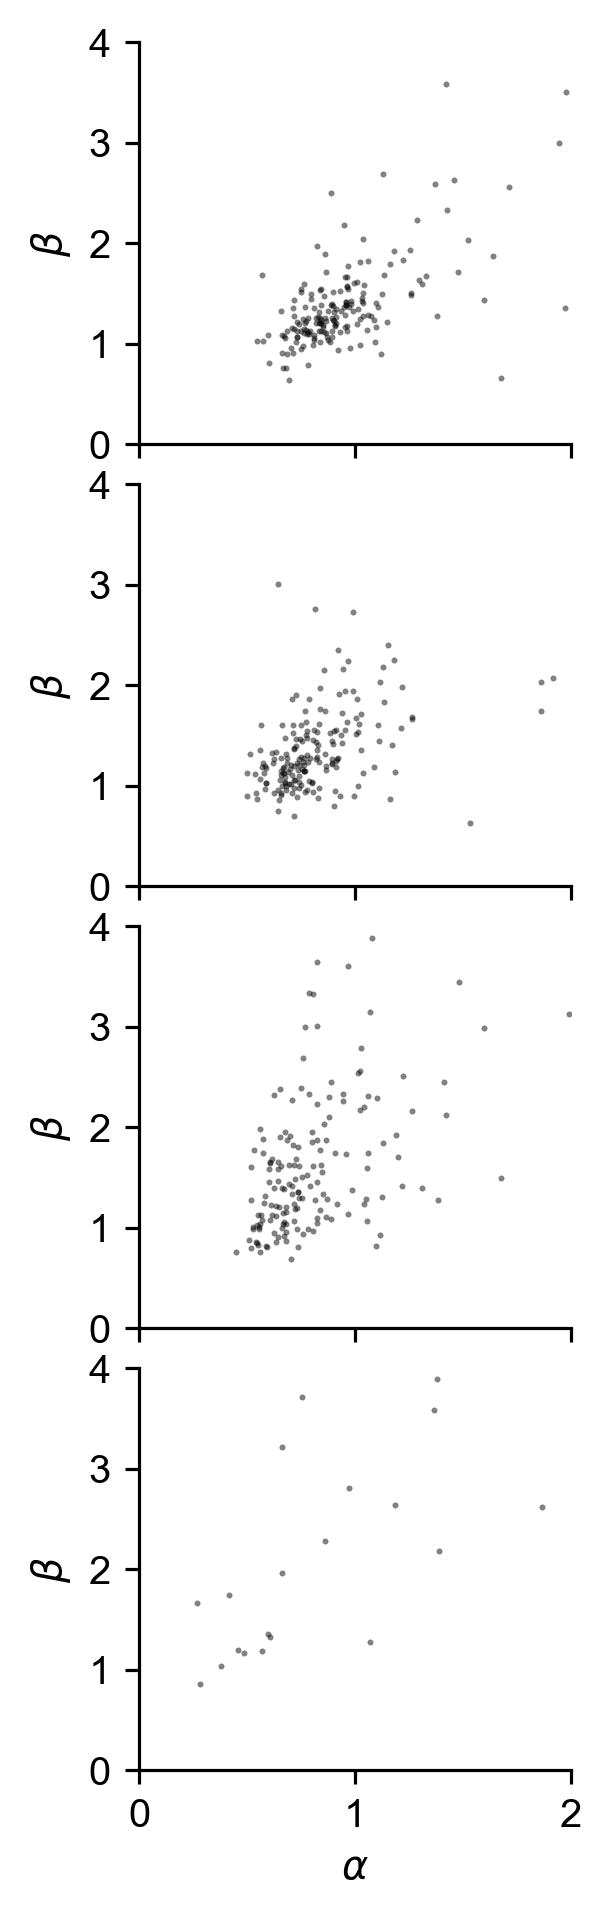

In [46]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in lvmfits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()

In [47]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in rhmfits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()

NameError: name 'rhmfits' is not defined